In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# a) Define Algorithm for Gaussian Mixture Models with EM-Algorithm

In [2]:
def get_features(datapath, hasIndex=True):
    x = []
    file = open(datapath)
    for datapoint in file:
        if hasIndex:
            x.append([float(d)*0.1 for d in datapoint.split()[1:]])
        else:
            x.append([float(d)*0.1 for d in datapoint.split()])
    return np.stack(x, axis=1)

In [3]:
class Cluster:
    def __init__(self, X, k):
        #initilize mean, covariance, size(pi) for each feature
        #self.means = [random.uniform(np.min(f), np.max(f)) for f in X]
        self.means = (X.T[np.random.choice(X.shape[1]), :]).T
        #self.covs = [compute_covs(X, mean, 1, 1) for mean in self.means]
        self.cov = np.eye(X.shape[0]) #compute_covs(X, self.means, 1, 1)
        self.pi = 1./k
        self.R = np.zeros(X.shape[1])
    
    def update_params(self, means, cov, pi):
        self.means = means
        self.cov = cov
        self.pi = pi
        
    def update_R(self, R):
        self.R = R
        
    def normalize_R(self, R_M):
        self.R = np.array(self.R / np.sum(R_M, axis=0))
        self.m = np.sum(self.R)

In [4]:
def initilize_clusters(X, k):
    clusters = []
    for i in range(k):
        clusters.append(Cluster(X, k))
    return clusters

In [5]:
def update_params(c, X):
    m = compute_mean(X, c.R, c.means)
    cov = compute_covs(m[1], m[0], c.R, c.m)
    p = compute_pi(X.shape[1], c.m)
    c.update_params(m[0], cov, p)

In [6]:
def compute_covs(X, mean, r, m):
    return np.array( 1/np.array(m) * np.dot(np.multiply(X, r), X.T) )

In [7]:
def compute_mean(X, r, m):
    mean = 1./np.array(m) * np.sum(r * X, axis=1)
    x_m = np.matrix((X.T - mean).T)
    return (mean, x_m)

In [8]:
def compute_pi(n, m):
    return 1. / n * np.array(m)

In [140]:
def compute_R(X, cl):
    return cl.pi * multi_variat_gauss(X, cl.means, cl.cov)

def multi_variat_gauss(X, mean, cov):
    fst = np.linalg.det(cov) ** -.5 ** (2*np.pi) ** (X.shape[0]/2)
    #dot = np.dot(np.linalg.pinv(cov), (X.T - mean).T).T
    dot = np.dot(np.linalg.inv(cov + np.eye(len(mean))*1e-15), (X.T - mean).T).T
    snd = np.exp(-.5 * np.einsum('ij, ij -> i', X.T -mean, dot))
    return fst*snd

In [154]:
#EM-Algo:
def EM(datapath, k, iterations, delta):
    data = get_features(datapath)
    clusters = initilize_clusters(data, k)
    lls = []

    for step in range(iterations):
        #Initilize responsibility-matrix
        R_m = []
        #E-Step:
        for c in clusters:
            R = compute_R(data, c)
            c.update_R(R)
            R_m.append(R)
        R_m = np.array(R_m)
        #Normalize Responsibilities
        for c in clusters:
            c.normalize_R(R_m)
        #compute loglikelihood
        ll = np.sum(np.log(np.sum(R_m, axis=0)))
        lls.append(ll)
        #M-Step:
        for c in clusters:
            update_params(c, data)
        if len(lls)>2 and (np.abs(np.abs(ll) - np.abs(lls[step-1])) <= delta or (np.abs(np.abs(ll) - np.abs(lls[step-2])) <= delta)):
            print("converged")
            return clusters, lls, ll
    return clusters, lls, ll

# b) Plot Clustering

In [92]:
path = 'faithful.dat'

In [164]:
def plot_clusters(datapath, k=3):
    #compute gaussians and responsibility
    gaussians, logls, lastlog = EM(datapath, k, 1000, 1)
    print(logls)
    print(gaussians[0].cov)
    data = get_features(datapath)
    #plot datapoints and most responsible gaussian
    colormap = []
    for i in range(data.shape[1]):
        best_c = None
        cid = 0
        for c in range(len(gaussians)):
            resp_c = gaussians[c].R[i]
            if best_c is None or best_c < resp_c:
                best_c = resp_c
                cid = c
        colormap.append(cid)

    #plot mean and covariance ellipse of each gaussian
    plt.scatter(data[0], data[1], c=colormap, alpha=0.5)
    for c in range(len(gaussians)):
        plt.scatter(gaussians[c].means[0], gaussians[c].means[1], c="yellow")#, c=list(set(colormap)))
        computeEllipse(gaussians[c].means, gaussians[c].cov)

from matplotlib.patches import Ellipse
def computeEllipse(mean, cov):
    def eigsorted(cov):
        ev, evec = np.linalg.eigh(cov)
        orderedIdx = ev.argsort()[::-1]
        return ev[orderedIdx], evec[:, orderedIdx]
    ax = plt.gca()
    ev, evec = eigsorted(cov)
    theta = np.degrees(np.arctan2(*evec[:,0][::-1]))
    width, height = 2 * 2 *np.sqrt(abs(ev))
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, alpha=0.1)
    ax.add_artist(ellipse)
    return ellipse

converged
[-199.90549889937154, -407.07260815565542, -346.60877880174701, -457.29376583564647, -368.02095773626456, -460.50158639916413, -359.45188696424714, -467.93804969134618, -384.36217517983664, -477.97928939846872, -404.36985409888325, -479.23219271766527, -411.30364852436355, -478.58552445382799]
[[ 0.00427751  0.02276116]
 [ 0.02276116  0.33556144]]


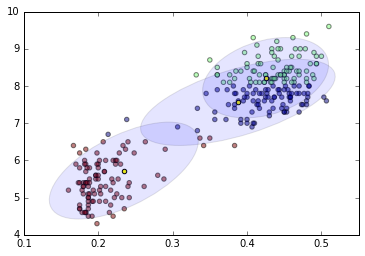

In [165]:
plot_clusters(path)

# c) Determine best k

In [187]:
#determine best k:
def test_for_ks(numKs = 10):
    ks = []
    logs = []
    for k in range(2, numKs):
        _, logls, _ = EM(path, k, 100, 1)
        ks.append(k)
        logs.append(logls[-1])
    return ks, logs

In [188]:
ks, logs = test_for_ks(15)

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


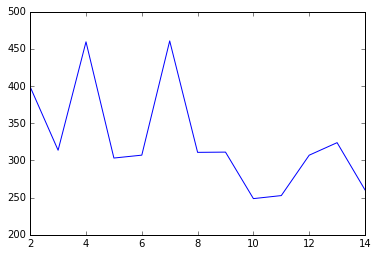

In [189]:
plt.plot(ks, np.abs(logs))
plt.show()
plt.close()